In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import sys

sys.path.insert(0, 'modules/')
    
from chromosome_data_processor import * 
from lengths_data_processor import *

In [3]:
data = pd.read_csv('datasets/CytoScan.Segmental.Reports/OS001_events.txt', sep='\t', comment='#')

In [4]:
data = process_chromosome_data(data)

data

,Chromosome,Copy Number,Length,Start,End
0,1,3,1961264,3699709,5660972
1,1,3,1898488,6923109,8821596
3,1,3,3223208,12392108,15615315
15,1,3,1522222,60470133,61992354
22,1,3,13965171,69521787,83486957
...,...,...,...,...,...
764,Y,3,90619,25623467,25714085
765,Y,3,36116,25789995,25826110
766,Y,3,185678,26147446,26333123
767,Y,3,392040,27012136,27404175


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 768
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Chromosome   187 non-null    object
 1   Copy Number  187 non-null    int64 
 2   Length       187 non-null    int64 
 3   Start        187 non-null    int64 
 4   End          187 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 8.8+ KB


In [6]:
lengths = pd.read_csv('datasets/hs37d5.fa.fai', sep='\t', header=None)

In [7]:
lengths = process_lengths_data(lengths)

lengths

,Length
Chromosome,
1,249250621
2,243199373
3,198022430
4,191154276
5,180915260
6,171115067
7,159138663
8,146364022
9,141213431


In [8]:
def update_bin_value(_bin, bin_start, bin_end, event_start, event_end, event_cn):
    if event_start < bin_start and event_end >= bin_start:
        update_start = 0
        if event_end < bin_end:
            update_end = event_end - bin_start + 1
        else:
            update_end = bin_end
            
        _bin[update_start:update_end] = event_cn
        
    elif event_start <= bin_end and event_end >= bin_end:
        update_end = bin_end
        if event_start > bin_start:
            update_start = event_start - bin_start + 1
        else:
            update_start = 0
            
        _bin[update_start:update_end] = event_cn
        
    elif event_start >= bin_start and event_end < bin_end:
        update_start = event_start - bin_start + 1
        update_end = event_end - bin_start + 1
        
        _bin[update_start:update_end] = event_cn
    

def split_chromosome_to_bins(chromosome_data, chromosome_len, bin_len=30000):
    bins = []
    for base in range(0, chromosome_len, bin_len):
        if chromosome_len - base < bin_len:  # last short bin
            curr_bin_len = chromosome_len - base
        else:
            curr_bin_len = bin_len
            
        _bin = np.full((curr_bin_len), 2)
        
        bin_start = base
        bin_end = base + bin_len
        
        for index, row in chromosome_data.iterrows():
            event_start = row['Start']
            event_end = row['End']
            event_copy_number = row['Copy Number']
            
            update_bin_value(_bin, bin_start, bin_end, event_start, event_end, event_copy_number)
        
        bin_avg = np.average(_bin)
        bins.append(bin_avg)
    
    return bins

In [9]:
chr6 = data[data['Chromosome'] == '6']

chr6

,Chromosome,Copy Number,Length,Start,End
179,6,1,32969007,0,32969006
184,6,1,25136920,33023971,58160890
191,6,1,48000997,61000000,109000996
195,6,4,5939,109000996,109006934
198,6,1,62108134,109006934,171115067


In [10]:
chr6_len = lengths.loc[['6']]['Length'].item()

chr6_len

171115067

In [11]:
ch6_bins = split_chromosome_to_bins(chr6, chr6_len)

In [12]:
def plot_bins(bins):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(bins, color='k')
    ax.set_ylim([-0.5, 4.5])
    ax.set_xlim([0, len(bins)])

    ax.axhline(y=2, color='gray', dashes=(5, 5))

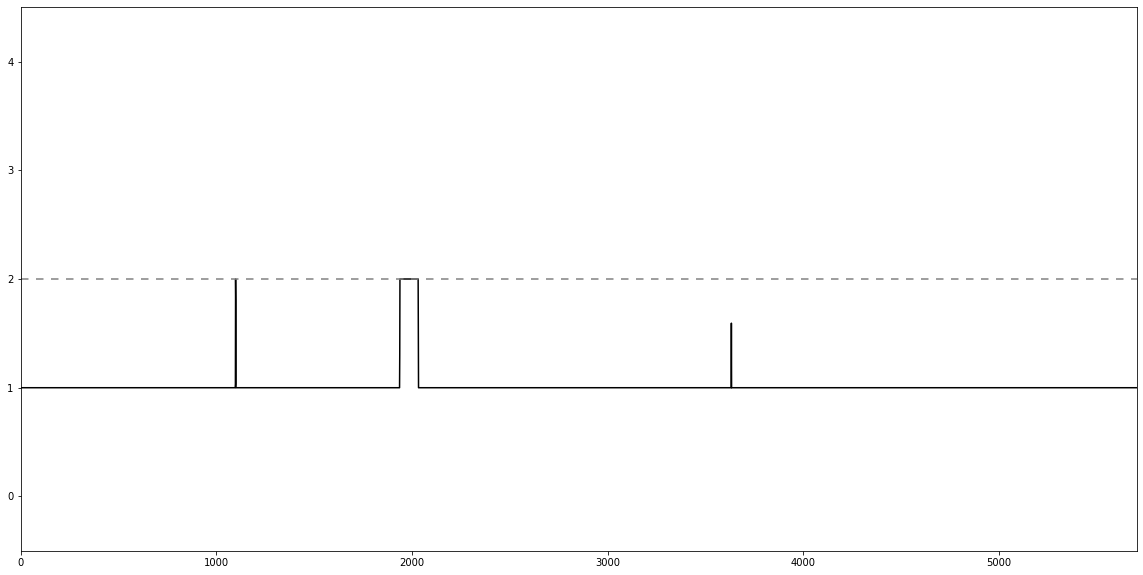

In [13]:
plot_bins(ch6_bins)

In [14]:
def scatter_bins(bins):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(range(len(bins)), bins, c='k', s=8)
   
    ax.set_ylim([-0.5, 4.5])
    ax.set_xlim([0, len(bins)])

    ax.axhline(y=2, color='gray', dashes=(5, 5))

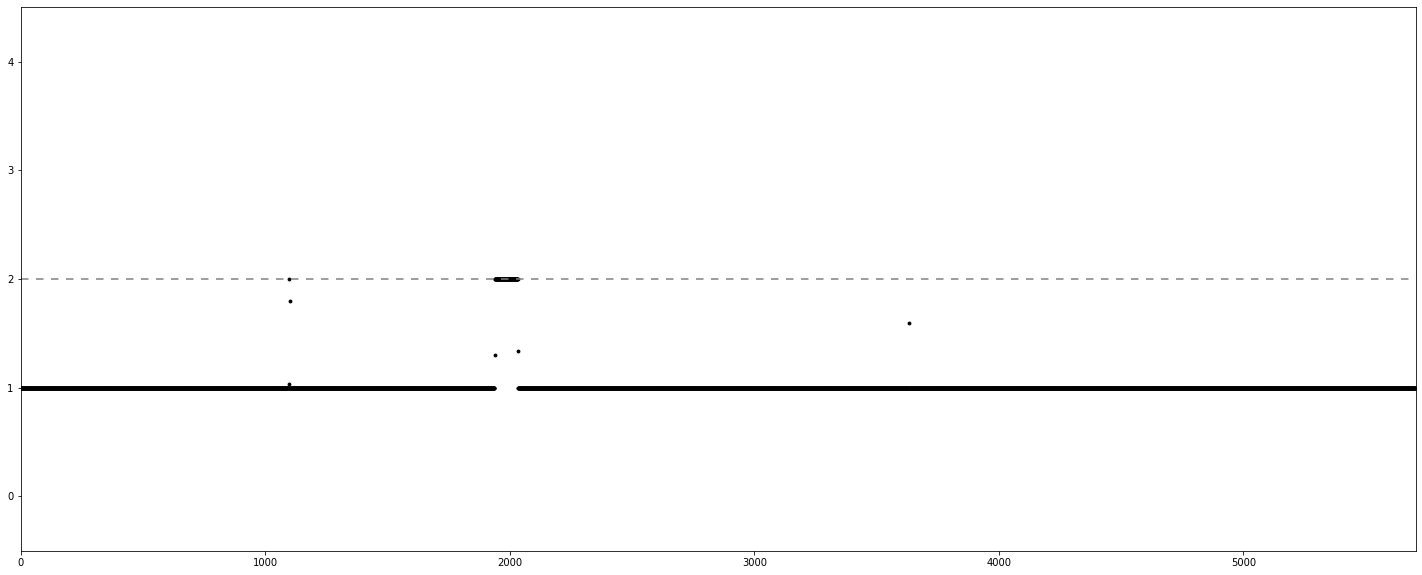

In [15]:
scatter_bins(ch6_bins)

In [16]:
chromosome_names = [str(_chr) for _chr in range(1, 23)]
chromosome_names.extend(['X', 'Y'])

chromosome_names

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 'X',
 'Y']

In [17]:
def split_chromosomes_to_bins(data):
    bins = []
    
    for _chr in chromosome_names[:-2]:
        chr_data = data[data['Chromosome'] == _chr]
        chr_len = lengths.loc[[_chr]]['Length'].item()
        chr_bins = split_chromosome_to_bins(chr_data, chr_len)
        bins.append(chr_bins)
        
    return bins

In [18]:
bins = split_chromosomes_to_bins(data)

In [62]:
def flatten_bins(bins):
    return [value for _chr in bins for value in _chr]

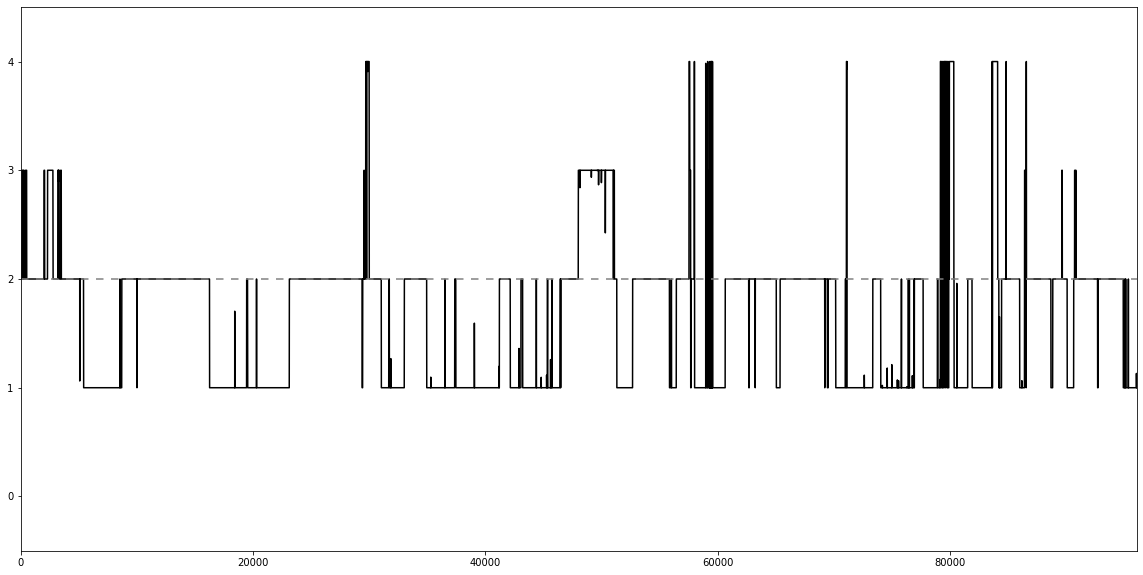

In [64]:
flattened_bins = flatten_bins(bins)

plot_bins(flattened_bins)

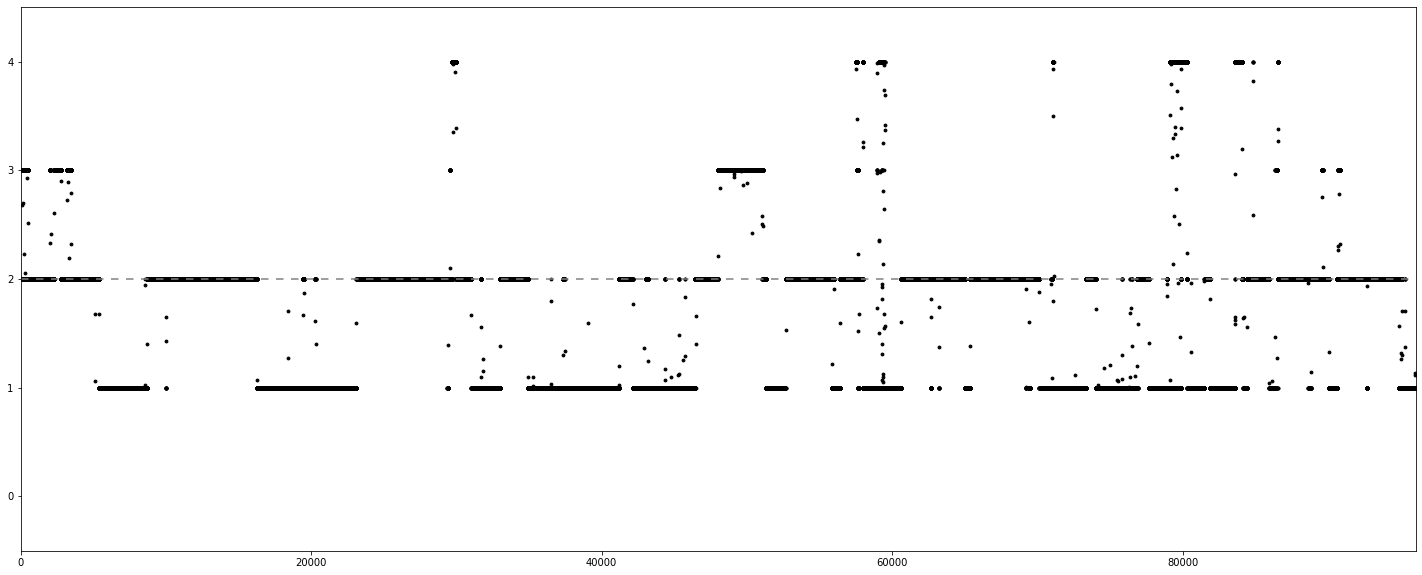

In [65]:
scatter_bins(flattened_bins)

In [27]:
def count_chromosome_area(chromosome_bins):
    area = 0
    for _bin in chromosome_bins:
        area += abs(_bin - 2)
        
    return area

In [28]:
chr6_bins = split_chromosome_to_bins(chr6, chr6_len)

In [29]:
chr6_area = count_chromosome_area(chr6_bins)

chr6_area

5606.937033333334

In [31]:
def count_chromosomes_areas(bins):
    areas = []
    for _chr in bins:
        #chr_data = data[data['Chromosome'] == _chr]
        #chr_len = lengths.loc[[_chr]]['Length'].item()
        #chr_bins = split_chromosome_to_bins(chr_data, chr_len)
        chr_area = count_chromosome_area(_chr)
        areas.append(chr_area)
        
    return areas

In [33]:
areas = count_chromosomes_areas(bins)

areas

[3811.8467333333333,
 557.4807666666666,
 6497.4726,
 106.40056666666666,
 3053.0037666666667,
 5606.937033333334,
 4199.945166666667,
 3100.6354999999994,
 1510.349,
 3292.0774333333325,
 154.81106666666668,
 404.0938,
 3186.6233,
 2845.543966666667,
 3375.7688333333335,
 2635.9119333333333,
 1514.8074666666669,
 524.8522666666667,
 751.4173666666667,
 95.7317,
 0.0,
 1115.5169]

In [34]:
len(areas)

22

In [45]:
def visualize_areas_bar(areas):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(chromosome_names[:-2], areas)
    #ax.set_ylim([0, 7000])

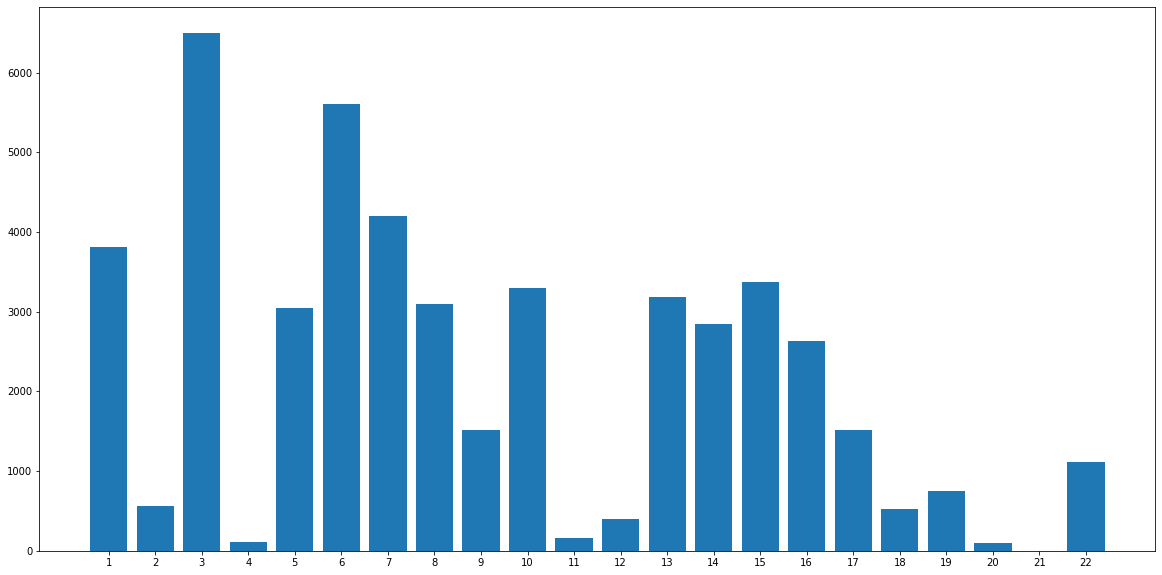

In [46]:
visualize_areas_bar(areas)

In [49]:
def count_relative_areas(areas, bins):
    relative_areas = []
    for idx, area in enumerate(areas):
        chr_len = len(bins[idx])
        relative_area = area / chr_len
        relative_areas.append(relative_area)
        
    return relative_areas

In [50]:
relative_areas = count_relative_areas(areas, bins)

relative_areas

[0.4587611906767762,
 0.06876535915464001,
 0.9843164066050598,
 0.016698142916928227,
 0.5062184988669651,
 0.9829833508648902,
 0.791695601633679,
 0.6355063537610165,
 0.32080480033984704,
 0.728658130441198,
 0.03439481596682219,
 0.090563379650381,
 0.830065980724147,
 0.7950667691161406,
 0.9876444802028477,
 0.8751367640548915,
 0.5595890161310184,
 0.2016336022538097,
 0.3812366142398106,
 0.04556482627320324,
 0.0,
 0.6519677966101696]

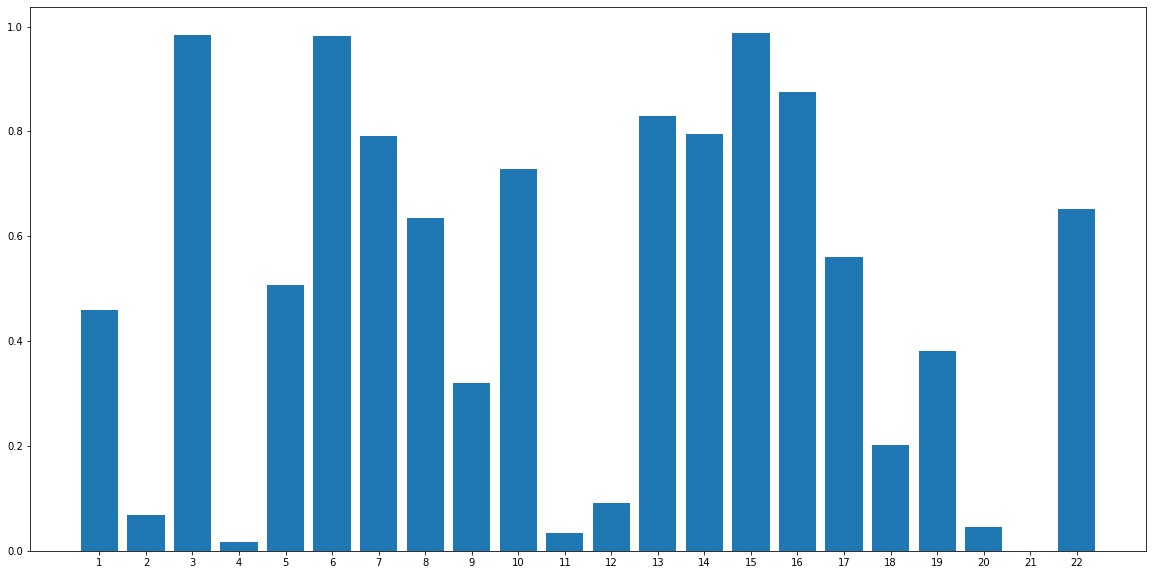

In [51]:
visualize_areas_bar(relative_areas)

In [52]:
data2 = pd.read_csv('datasets/CytoScan.Segmental.Reports/OS007_events.txt', sep='\t', comment='#')

In [53]:
data2 = process_chromosome_data(data2)

data2

,Chromosome,Copy Number,Length,Start,End
0,1,3,35902120,0,35902119
7,1,4,50082064,36958762,87040825
16,1,4,17259570,87043855,104303424
23,1,4,13442894,104308161,117751054
28,1,4,3587817,117751501,121339317
...,...,...,...,...,...
775,X,3,469421,147322761,147792181
776,X,3,4337,147795632,147799968
777,X,3,449103,147800507,148249609
779,X,3,4853232,148301353,153154584


In [54]:
chr6_2 = data2[data2['Chromosome'] == '6']

chr6_2

,Chromosome,Copy Number,Length,Start,End
337,6,4,30676227,1179129,31855355
346,6,1,33445,32671461,32704905
355,6,3,17731023,41010475,58741497
360,6,3,1496579,61000000,62496578
363,6,4,363645,63073845,63437489
364,6,4,70579,71838860,71909438
370,6,4,36102758,92237248,128340005
375,6,4,18982781,128344631,147327411
378,6,4,23773816,147341252,171115067


In [55]:
bins2 = split_chromosomes_to_bins(data2)

In [56]:
bins2

[[3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,

In [67]:
flattened_bins2 = flatten_bins(bins2)

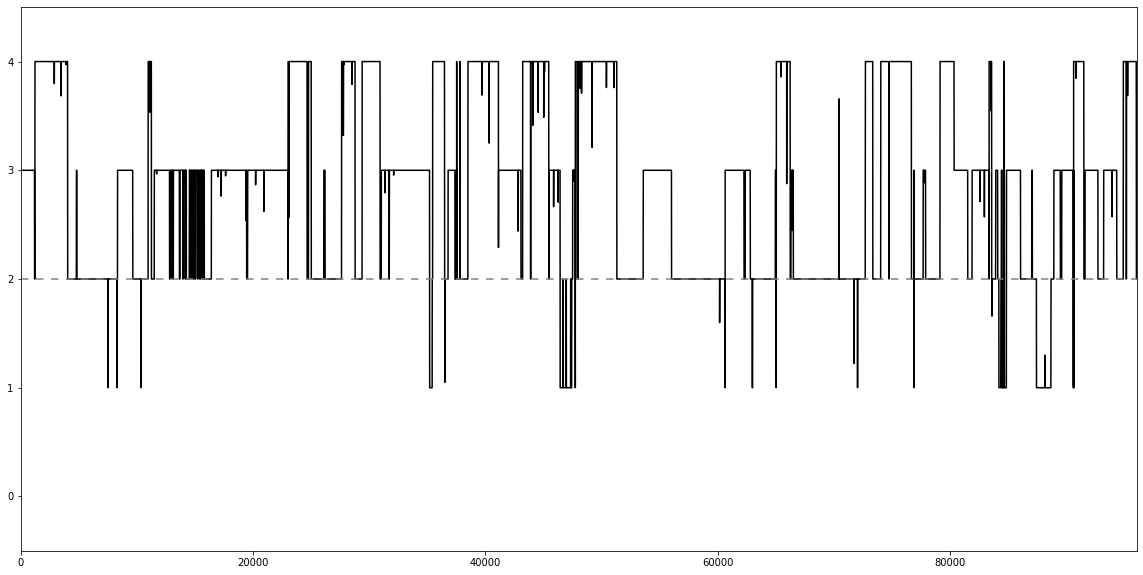

In [73]:
plot_bins(flattened_bins2)

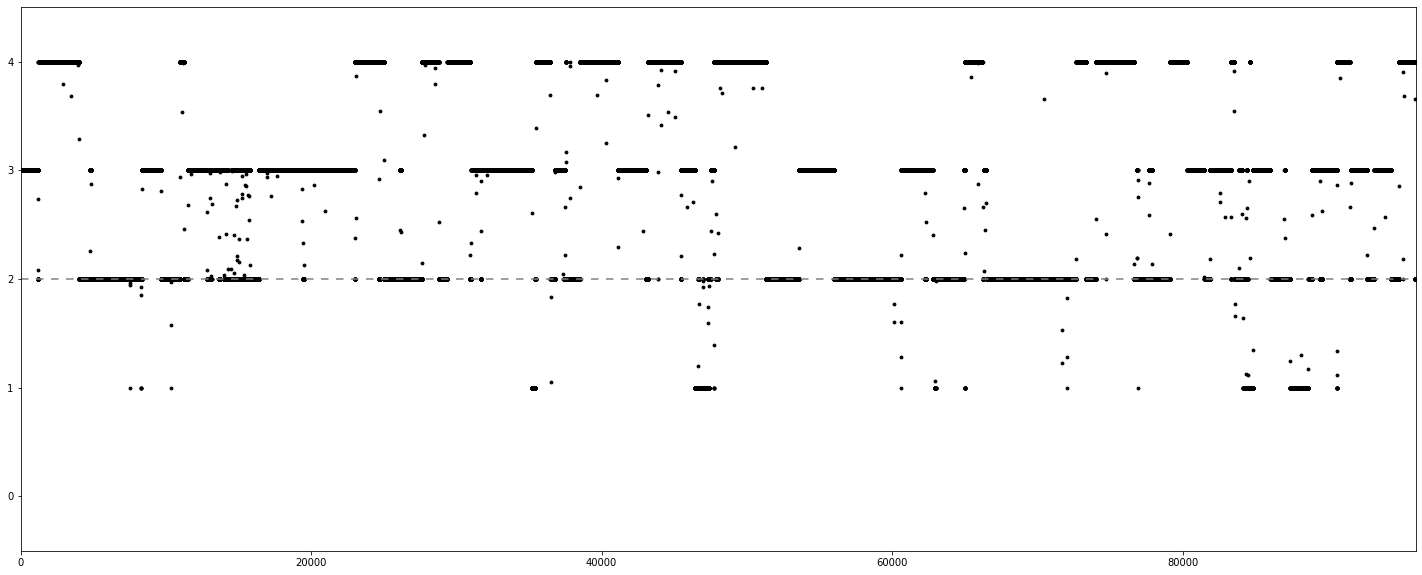

In [74]:
scatter_bins(flattened_bins2)

In [99]:
def count_cnv_rate(data):
    genome_length = lengths['Length'].sum(axis=0)
    cnv_events_length = data['Length'].sum(axis=0)
    
    return cnv_events_length / genome_length

In [100]:
count_cnv_rate(data)

0.4546097066007858

In [101]:
count_cnv_rate(data2)

0.6337624228528628

In [68]:
from collections import Counter

In [70]:
def intersection(s1, s2) : 
  
    # Find the intersection of the two sets  
    intersect = list((Counter(s1) & Counter(s2)).elements())

    return intersect


def jaccard(bins1, bins2):
    # Sizes of both the sets  
    size1 = len(bins1)
    size2 = len(bins2)  
  
    # Get the intersection set  
    intersect = intersection(bins1, bins2)
  
    # Size of the intersection set  
    size_in = len(intersect)
  
    # Calculate the Jaccard index  
    # using the formula  
    jaccard_in = size_in  / (size1 + size2 - size_in)  
  
    # Return the Jaccard index  
    return jaccard_in

In [72]:
jaccard_in = jaccard(flattened_bins, flattened_bins2)

jaccard_in

0.2928641619664275